In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from libdeeppatcher.arachne import Arachne
from libdeeppatcher import utils
from libdeeppatcher.types import Dataset
from libdeeppatcher import prepare
from libdeeppatcher import report
from libdeeppatcher import metrics
from IPython.display import clear_output
from keras import backend as K

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve
import lightgbm as lgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 5
sns.set_context('paper', font_scale=2)

# Load the repairs / side-effects data of each dataset and model

In [43]:
model_and_dataset = [
    ('mnist_dense', 'mnist_flat'),
    ('mnist_dense5', 'mnist_flat'),
    ('mnist_convolutional', 'mnist_conv'),
    ('mnist_conv4', 'mnist_conv'),
    ('fmnist_dense', 'fmnist_flat'),
    ('fmnist_dense5', 'fmnist_flat'),
    ('fmnist_convolutional', 'fmnist_conv'),
    ('fmnist_conv4', 'fmnist_conv'),
]

In [44]:
# check size of each dataset
df_list = []
for model_name, dataset_name in model_and_dataset:
    print(model_name, dataset_name)
    tmp = pd.read_csv('./repairability_dataset/'+model_name+'.csv', index_col=0)
    print(tmp.shape)
    df_list.append(tmp)

mnist_dense mnist_flat
(47, 6)
mnist_dense5 mnist_flat
(58, 6)
mnist_convolutional mnist_conv
(37, 6)
mnist_conv4 mnist_conv
(32, 6)
fmnist_dense fmnist_flat
(299, 6)
fmnist_dense5 fmnist_flat
(380, 6)
fmnist_convolutional fmnist_conv
(226, 6)
fmnist_conv4 fmnist_conv
(283, 6)


# Concat dataframes and Make objective variable
The history of repair for each dataset is combined into a single dataframe.

Only faults that are successfully repaired all five times are treated as repaired data (the objective variable is True).

In [45]:
df = pd.concat(df_list, ignore_index=True)
df['result'] = (df['success_num']==5)
df.drop('success_num', axis=1, inplace=True)
display(df)
display(df['result'].value_counts())

,pcs,entropy,label_pred_score,loss,result
0,0.033491,1.374434,0.455535,0.786283,True
1,0.056950,2.303669,0.303728,1.191622,True
2,0.200909,1.592171,0.212778,1.547508,True
3,0.916573,0.323528,0.035939,3.325940,False
4,0.157016,1.706133,0.005314,5.237495,False
...,...,...,...,...,...
1357,0.817529,0.595737,0.075552,2.582941,False
1358,0.303060,1.259616,0.312652,1.162663,True
1359,0.952955,0.252968,0.014627,4.224856,False
1360,0.125183,1.268987,0.053213,2.933449,False


True     1020
False     342
Name: result, dtype: int64

# Hold test data

In [46]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=777)
X_test, y_test = df_test.drop('result', axis=1), df_test['result']

In [47]:
train_pos_ratio = df_train['result'].sum() / df_train['result'].shape[0]
test_pos_ratio = df_test['result'].sum() / df_test['result'].shape[0]
print(f'train_pos_ratio = {train_pos_ratio} ({df_train["result"].sum()}/{df_train["result"].shape[0]})')
print(f'test_pos_ratio = {test_pos_ratio} ({df_test["result"].sum()}/{df_test["result"].shape[0]})')

train_pos_ratio = 0.7493112947658402 (816/1089)
test_pos_ratio = 0.7472527472527473 (204/273)


# Check the distribution of each column of training data

In [48]:
df_train.describe()

,pcs,entropy,label_pred_score,loss
count,1089.000000,1089.000000,1.089000e+03,1089.000000
mean,0.426543,1.073190,2.241212e-01,1.941679
std,0.294290,0.484487,1.436282e-01,1.374043
min,0.000676,0.001127,5.842331e-07,0.705380
25%,0.165685,0.777036,9.622703e-02,1.060431
50%,0.378685,1.069662,2.206753e-01,1.511063
75%,0.665564,1.367932,3.463065e-01,2.341045
max,0.999892,2.714751,4.939210e-01,14.352965


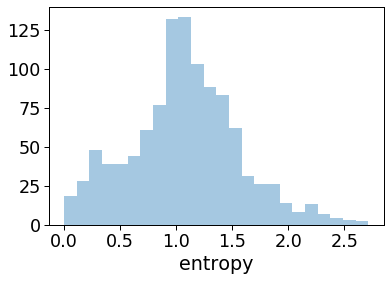

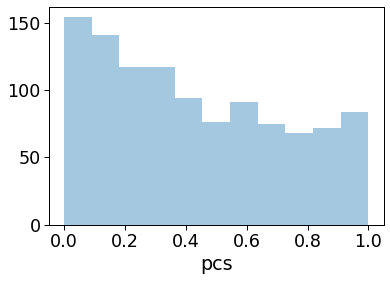

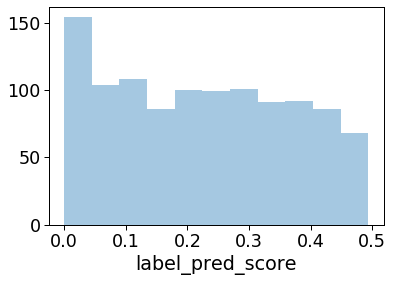

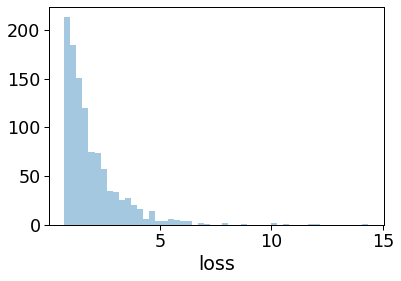

In [49]:
sns.distplot(df_train['entropy'], kde=False)
plt.show()
sns.distplot(df_train['pcs'], kde=False)
plt.show()
sns.distplot(df_train['label_pred_score'], kde=False)
plt.show()
sns.distplot(df_train['loss'], kde=False)
plt.show()

In [50]:
# Since loss is a long-tale distribution, let's try a logarithmic transformation
df_train['loss'] = df_train['loss'].apply(np.log)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


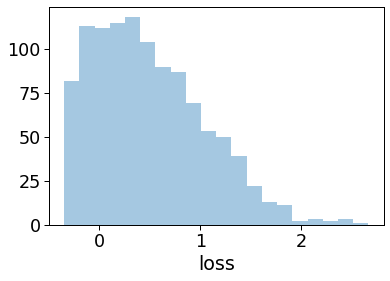

In [51]:
sns.distplot(df_train['loss'], kde=False)
plt.show()

# Standardize each column in the training data

In [52]:
df_train_std = df_train.copy()
scaled_columns = [feat for feat in list(df_train.columns) if feat != 'result']
std = StandardScaler()
sc_train = std.fit(df_train[scaled_columns])
std_cols = sc_train.transform(df_train[scaled_columns])
df_train_std[scaled_columns] = std_cols

In [53]:
df_train_std.describe()

,pcs,entropy,label_pred_score,loss
count,1.089000e+03,1.089000e+03,1.089000e+03,1.089000e+03
mean,4.669258e-17,1.719113e-16,-6.626676e-18,1.113281e-16
std,1.000459e+00,1.000459e+00,1.000459e+00,1.000459e+00
min,-1.447762e+00,-2.213795e+00,-1.561139e+00,-1.545081e+00
25%,-8.868011e-01,-6.115521e-01,-8.908620e-01,-7.990334e-01
50%,-1.626947e-01,-7.285346e-03,-2.400309e-02,-1.509905e-01
75%,8.125690e-01,6.086390e-01,8.510960e-01,6.501176e-01
max,1.949139e+00,3.389801e+00,1.879323e+00,3.968414e+00


# Balance labels on training data

In [54]:
df_train_std['result'].value_counts()

True     816
False    273
Name: result, dtype: int64

In [55]:
# Undersampling is used to reduce rows where the objective variable is True.
def under_sampling(data: pd.DataFrame):
    low_frequency_data_sample = data[data['result'] == False]
    low_frequency_data_size = len(low_frequency_data_sample)
    
    high_frequency_data_indeces = data[data['result'] == True].index

    np.random.seed(seed=7)
    random_indices = np.random.choice(high_frequency_data_indeces, low_frequency_data_size, replace=False)
    high_frequency_data_sample = data.loc[random_indices]
    
    merged_data = pd.concat([high_frequency_data_sample, low_frequency_data_sample], ignore_index=True)
    balanced_data = pd.DataFrame(merged_data)
    return balanced_data

In [56]:
df_uns = under_sampling(df_train_std)
display(df_uns['result'].value_counts())

True     273
False    273
Name: result, dtype: int64

# Examine the relationship of each metric to the objective variable

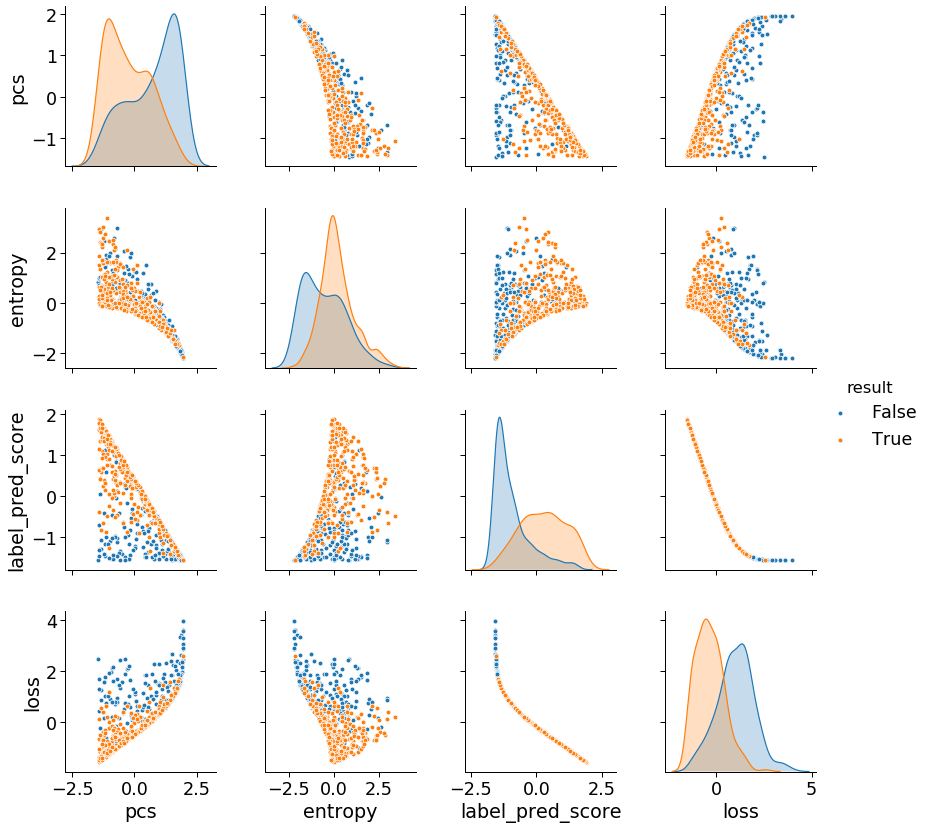

In [57]:
sns.pairplot(df_uns,
             vars=[
                 'pcs',
                 'entropy',
                 'label_pred_score',
                 'loss'
             ],
             height=3,
             hue='result',
            )
plt.show()

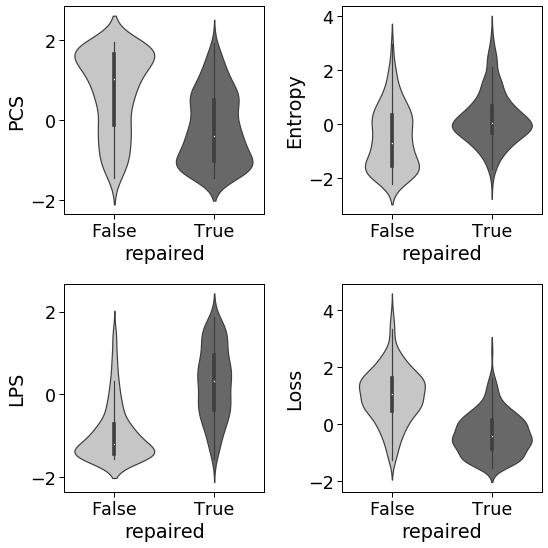

In [58]:
tmp_df = df_uns.copy()
tmp_df.columns = ['PCS', 'Entropy', 'LPS', 'Loss', 'repaired']
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(8, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
feats = [feat for feat in list(tmp_df.columns) if feat != 'result']
for ax, feat in zip(axes.flatten(), feats):
    sns.violinplot(data=tmp_df, x='repaired', y=feat, palette='Greys', ax=ax)
fig.tight_layout()
fig.show()
fig.savefig("./repairable_violin.pdf", format='pdf', dpi=300, bbox_inches='tight')

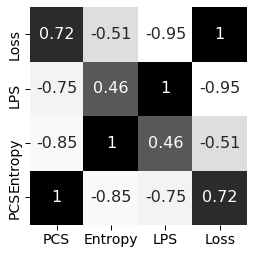

In [59]:
tmp_df = df_uns.copy()
tmp_df.columns = ['PCS', 'Entropy', 'LPS', 'Loss', 'result']
sns.heatmap(
    tmp_df.drop(['result'], axis=1).corr(),
    square=True, cbar=False, annot=True, cmap='Greys',annot_kws={"size":16}
)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 4)
plt.savefig('./repairable_corr.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Build a logistic regression model
We perform 5-fold cross-validation.

In [60]:
display(df_uns)
X_train, y_train = df_uns.drop(['result'], axis=1), df_uns['result']
display(X_train)
display(y_train)

,pcs,entropy,label_pred_score,loss,result
0,-1.137898,0.719594,-0.869756,0.625723,True
1,-0.027095,0.604761,-0.199405,-0.009848,True
2,-0.281784,2.092634,-0.866803,0.622343,True
3,0.877633,-0.666173,-0.524687,0.273116,True
4,-0.864568,0.154658,1.244634,-1.080382,True
...,...,...,...,...,...
541,-0.162804,0.076300,0.505332,-0.549825,False
542,1.034838,-0.718370,-0.735325,0.479269,False
543,-0.274668,0.134436,0.577955,-0.602594,False
544,0.813567,0.131252,-1.430361,1.619023,False


,pcs,entropy,label_pred_score,loss
0,-1.137898,0.719594,-0.869756,0.625723
1,-0.027095,0.604761,-0.199405,-0.009848
2,-0.281784,2.092634,-0.866803,0.622343
3,0.877633,-0.666173,-0.524687,0.273116
4,-0.864568,0.154658,1.244634,-1.080382
...,...,...,...,...
541,-0.162804,0.076300,0.505332,-0.549825
542,1.034838,-0.718370,-0.735325,0.479269
543,-0.274668,0.134436,0.577955,-0.602594
544,0.813567,0.131252,-1.430361,1.619023


0       True
1       True
2       True
3       True
4       True
       ...  
541    False
542    False
543    False
544    False
545    False
Name: result, Length: 546, dtype: bool

In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'C': [10**i for i in range(-2, 4)], 'random_state': [1234]}
clf_log = LogisticRegression()
grid_log = GridSearchCV(clf_log, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_log.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.01, random_state=1234 .......................................
[CV] ........................ C=0.01, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ......................... C=0.1, random_state=1234, total=   0.0s
[CV] C=0.1, random_state=1234 ........................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'random_state': [1234]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=2)

In [62]:
def preprocess_test(X_test, sc_train, is_losslog=True):
    X_test_std = X_test.copy()
    if is_losslog:
        X_test_std['loss'] = X_test['loss'].apply(np.log)
    std_cols = sc_train.transform(X_test_std)
    X_test_std = std_cols
    return X_test_std
    

def print_perf(clf, X, y):
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f'Accurcy: {acc:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1: {f1:.3}\n')
    
def plot_conf_mat(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Reds', fmt='d')
    plt.ylim(0, cm.shape[0])
    plt.ylabel('true')
    plt.xlabel('pred')


Accurcy: 0.799
Precision: 0.801
Recall: 0.795
F1: 0.798

Accurcy: 0.806
Precision: 0.922
Recall: 0.809
F1: 0.862



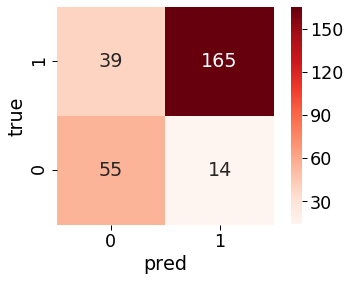

In [63]:
# the performance for training data
print_perf(grid_log, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train) # the same transformation as training data
print_perf(grid_log, X_test_std, y_test)
plot_conf_mat(grid_log, X_test_std, y_test)

# Build a LightGBM model
We perform 5-fold cross-validation.

In [64]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'max_depth': [10, 25, 50, 75],
              'learning_rate': [0.001, 0.01, 0.05, 0.1],
              'n_estimators': [10, 50, 100, 200, 500]
}
clf_lgb = lgb.LGBMClassifier(random_state=1234)
grid_lgb = GridSearchCV(clf_lgb, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=10 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=10, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  lea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=50 ..............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=100 .............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=100 .............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=100 .............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=100 .............
[CV]  learning_rate=0.001, max_depth=10, n_estimators=100, total=   0.0s
[CV] learning_rate=0.001, max_depth=10, n_estimators=100 .........

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   26.3s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=1234, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_gri

Accurcy: 0.813
Precision: 0.79
Recall: 0.853
F1: 0.82

Accurcy: 0.81
Precision: 0.9
Recall: 0.838
F1: 0.868



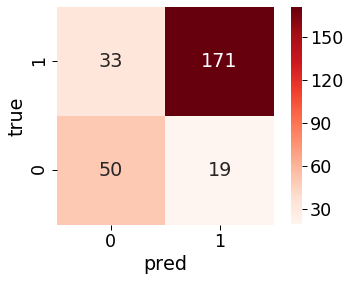

In [65]:
# the performance for training data
print_perf(grid_lgb, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train)
print_perf(grid_lgb, X_test_std, y_test)
plot_conf_mat(grid_lgb, X_test_std, y_test)

# Build a random forest model
We perform 5-fold cross-validation.

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
parameters = {'n_estimators': [50, 60, 70, 80, 90, 100], 'max_depth': [5, 10, 50]}
clf_rf = RandomForestClassifier(criterion='entropy', random_state=1234)
grid_rf = GridSearchCV(clf_rf, param_grid=parameters, cv=kf, scoring='accuracy', verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=50 ....................................
[CV] ..................... max_depth=5, n_estimators=50, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] ..................... max_depth=5, n_estimators=60, total=   0.1s
[CV] max_depth=5, n_estimators=60 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   13.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              

Accurcy: 0.817
Precision: 0.787
Recall: 0.868
F1: 0.826

Accurcy: 0.817
Precision: 0.901
Recall: 0.848
F1: 0.874



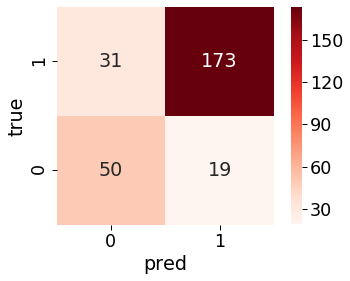

In [67]:
# the performance for training data
print_perf(grid_rf, X_train, y_train)
# the performance for test data
X_test_std = preprocess_test(X_test, sc_train)
print_perf(grid_rf, X_test_std, y_test)
plot_conf_mat(grid_rf, X_test_std, y_test)

# ROC / PR curves and calculate the AUC
The three models are compared in terms of ROC/PR curves and AUC.

In [68]:
res_log, res_lgb, res_rf = \
    grid_log.predict(X_test_std).astype(int), grid_lgb.predict(X_test_std).astype(int), grid_rf.predict(X_test_std).astype(int)
proba_log, proba_lgb, proba_rf = \
    grid_log.predict_proba(X_test_std), grid_lgb.predict_proba(X_test_std), grid_rf.predict_proba(X_test_std)

ROC

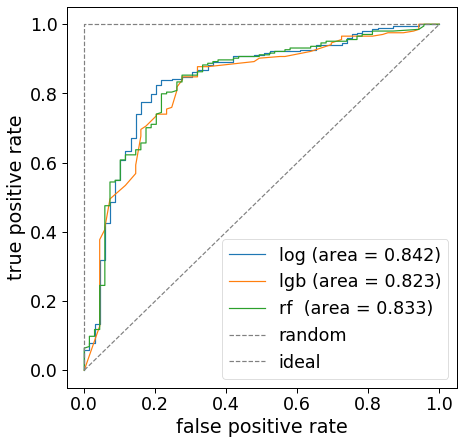

In [69]:
plt.subplots(figsize=(7,7))

fpr1, tpr1, thresholds = roc_curve(y_true=y_test, y_score=proba_log[:,1])
fpr2, tpr2, thresholds = roc_curve(y_true=y_test, y_score=proba_lgb[:,1])
fpr3, tpr3, thresholds = roc_curve(y_true=y_test, y_score=proba_rf[:,1])

plt.plot(fpr1, tpr1, label='log (area = %0.3f)' % auc(fpr1, tpr1))
plt.plot(fpr2, tpr2, label='lgb (area = %0.3f)' % auc(fpr2, tpr2))
plt.plot(fpr3, tpr3, label='rf  (area = %0.3f)' % auc(fpr3, tpr3))
plt.plot([0, 1], [0, 1], linestyle='--', label='random', c='gray')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal', c='gray')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


PR

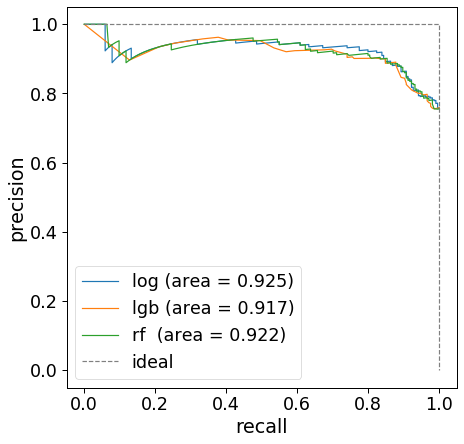

In [70]:
plt.subplots(figsize=(7,7))

pr1, re1, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_log[:,1])
pr2, re2, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_lgb[:,1])
pr3, re3, thresholds = precision_recall_curve(y_true=y_test, probas_pred=proba_rf[:,1])

plt.plot(re1, pr1, label='log (area = %0.3f)' % auc(re1, pr1))
plt.plot(re2, pr2, label='lgb (area = %0.3f)' % auc(re2, pr2))
plt.plot(re3, pr3, label='rf  (area = %0.3f)' % auc(re3, pr3))
plt.plot([0, 1, 1], [1, 1, 0], linestyle='--', label='ideal', c='gray')
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()